# Momentum Shift Score: Quantifying Career-Altering Moments in Major League Baseball

### Objectives:
This analysis focuses on identifying and evaluating pivotal moments in baseball games—specifically, events involving a pitched ball that result in the greatest changes in Win Probability Added (WPA). The goal is to assess how these moments influence the career trajectories of both the pitcher and the hitter. By quantifying this phenomenon into a single metric, we aim to provide a comprehensive narrative of how critical moments can shape the careers of the players involved.

### Table of Contents
| **Topic** | **Page** |
| --------- | -------- |
| **Analysis 1** : Pete Alonso HR off Devin Williams | 1 | 
| **Sentiment Analysis 1** | 2 |
| **Finding Pivotal Moments** | 3 |

### Definitions:
* A "moment" for which a Momentum Shift Score (MSS) can be assigned is a single pitch with an outcome. So a moment is all of a pithces attributes that are obtained from a Baseball Savant query

# Introduction

Baseball, often referred to as America’s pastime, is a sport deeply rooted in tradition and statistical analysis. Over the years, the advent of advanced metrics has revolutionized the way the game is understood, evaluated, and appreciated. Among these metrics, Win Probability Added (WPA) has emerged as a powerful tool to quantify the impact of individual plays on the outcome of a game. However, while WPA provides a game-level perspective, its implications on the career trajectories of players remain largely unexplored.

This project seeks to bridge that gap by introducing the concept of the Momentum Shift Score (MSS). The MSS is designed to quantify career-altering moments in Major League Baseball (MLB), focusing on pivotal events that result in significant changes in WPA. By analyzing these moments, we aim to uncover their influence on the long-term narratives of the players involved—both pitchers and hitters.

Through a combination of data-driven analysis and contextual storytelling, this project will highlight how singular moments, such as a critical home run or a game-changing strikeout, can define or redefine a player’s career. By leveraging tools like Statcast data, sentiment analysis, and historical context, we aim to provide a comprehensive framework for understanding the intersection of performance, pressure, and legacy in professional baseball. 

Ultimately, this research aspires to contribute to the broader discourse on sports analytics, offering a novel perspective on how individual moments resonate beyond the confines of a single game, shaping the legacies of players and the narratives of the sport itself.

In [2]:
from mss_helpers_ai import PlayerStats

import pandas as pd # for data manipulation
import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for data visualization
from sklearn.linear_model import LinearRegression # for regression analysis
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # for sentiment analysis
#from newspaper3k import Article # for web scraping
import datetime 
import requests # for web requests
import pybaseball as pyb # for baseball data
import plotly.graph_objects as go # for interactive plots
# custom functions and utils (create mss_helpers.py later)


/opt/anaconda3/envs/baseball/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
# Change batter_name to "Last, First" format if not already
def to_last_first(name):
    if pd.isnull(name):
        return name
    parts = name.split()
    if len(parts) >= 2:
        return f"{parts[-1]}, {' '.join(parts[:-1])}"
    return name

In [4]:
# load player ID spreadsheet
mlbIDs = pd.read_csv('../data/mlbIDs.csv')

# Only need name and ID associated with the player
mlbIDs = mlbIDs[['PLAYERNAME', 'MLBID']]
mlbIDs['MLBID'] = mlbIDs['MLBID'].fillna(0).astype(int)
mlbIDs['PLAYERNAME'] = mlbIDs['PLAYERNAME'].apply(to_last_first)

In [5]:
# USE ANYTIME DATA IS SCRAPED USING pybaseball.statcast()
# 
# function to clean statcast data
# creates batter name column: merges the ID with the player name
# renames the columns
# drops unnecessary ID column
def clean_statcast_data(df):
    df = df.merge(mlbIDs, left_on='batter', right_on='MLBID', how='left')
    df.rename(columns={'PLAYERNAME': 'batter_name'}, inplace=True)
    df.drop(columns=['MLBID'], inplace=True)
    df.rename(columns={'player_name': 'pitcher_name'}, inplace=True)
    return df

```python
# Load data

# Scrape the statcast data for 2015-2024
data_15_24 = stacast('2015-01-01', '2024-12-31')

# find moments where the win expectancy for either ream changed by 0.5 or more
pivotal_moment_data = data_15_24.loc[data_15_24['delta_home_win_exp'].abs() >= 0.5]

# clean the resulting data
pivotal_moment_data = clean_statcast_data(pivotal_moment_data)

# Create delta_home_win_exp_abs column before reordering
pivotal_moment_data['delta_home_win_exp_abs'] = pivotal_moment_data['delta_home_win_exp'].abs()

# Reorder columns to place delta_win_exp columns first and batter_name next to pitcher_name
cols = ['delta_home_win_exp', 'delta_home_win_exp_abs', 'pitcher_name', 'batter_name'] + \
    [col for col in pivotal_moment_data.columns if col not in ['delta_home_win_exp', 'delta_home_win_exp_abs', 'pitcher_name', 'batter_name']]

# Reorder the DataFrame
pivotal_moment_data = pivotal_moment_data[cols]

# Save the cleaned data to a new CSV file
pivotal_moment_data.to_csv('data/pivotal_moment_data.csv', index=False)
```

In [6]:
# Load the cleaned pivotal moment data from saved CSV

# Contains every pitch that resulted in a change in win expectancy by at least 50% from 2015-2024
# i.e. a "pivotal moment"
pivotal_moment_data = pd.read_csv('../data/pivotal_moment_data.csv')

# Change batter names to "Last, First" format
pivotal_moment_data['batter_name'] = pivotal_moment_data['batter_name'].apply(to_last_first)

# Drop columns that are completely empty (all values are NaN)
pivotal_moment_data = pivotal_moment_data.dropna(axis=1, how='all')
pivotal_moment_data = pivotal_moment_data.drop(columns=[col for col in ['hit_location', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z'] if col in pivotal_moment_data.columns])

In [7]:
# gets the pivotal moment data for a specific date and team and optional player inputs
def get_pivotal_moment(date=None, team=None, pitcher=None, batter=None):
    moment_data = pivotal_moment_data.copy()

    # Drop specified columns if they exist
    cols_to_drop = ['hit_location', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z']
    moment_data = moment_data.drop(columns=[col for col in cols_to_drop if col in moment_data.columns])

    if date:
        moment_data = moment_data[
            (moment_data['game_date'] == date)
            ]
        
    if team:
        moment_data = moment_data[
            ((moment_data['home_team'] == team) | 
             (moment_data['away_team'] == team))
            ]

    if pitcher:
        moment_data = moment_data[
            (moment_data['pitcher_name'] == pitcher)
            ]
    if batter:
        moment_data = moment_data[
            (moment_data['batter_name'] == batter)
            ]
    
    return moment_data

# Find commonalities amongst pivotal moments
* Exclude fielding dependent moments

* Split pivotal moments into three groups
    * Players who excelled after moment
    * Players who declined after moment
    * Players who played the same after moment
* Compare stats before (few seasons AND 10 games)
* Compare stats after 

* Plot WPA against various other stats/metrics

## Things thar might influence WPA
* Time of season
* Inning of game
* Difference in score
* Team standings at time
* Market size

## Player specific 
* Age (rookie, veteran)
* Power, Contact, etc.
* Amount of pivotal moments in career

## How?
* Tracking player performance 
    * Statistical outlier degree (how many standard deviations from player's normal performance?)

# Functions to get stats of players before and after moment

In [12]:
def calculate_mss_simple(moment_data, mlbIDs=None, days_after=30, print_details=False):
    """
    A simplified function to calculate Momentum Shift Score (MSS) for both pitcher and batter.
    The MSS score ranges from -100 to 100, where:
    - Positive values (0 to 100) indicate a positive trajectory change
    - Negative values (-100 to 0) indicate a negative trajectory change
    - 0 indicates no significant change in trajectory
    
    Parameters:
    -----------
    moment_data : pandas.DataFrame or pandas.Series
        Data about the pivotal moment - must contain 'batter_name', 'pitcher_name', and 'game_date'
    mlbIDs : pandas.DataFrame, optional
        DataFrame containing player IDs (must have 'PLAYERNAME' and 'MLBID' columns)
    days_after : int, optional
        Number of days after the moment to analyze (default: 30)
    print_details : bool, optional
        Whether to print detailed component breakdowns (default: False)
        
    Returns:
    --------
    dict
        Dictionary with MSS scores and details for both batter and pitcher
    """
    import pandas as pd
    from datetime import datetime, timedelta
    import pybaseball as pyb
    from mss_helpers_ai import PlayerStats
    
    # Ensure we have a Series (single row) from the moment_data
    if isinstance(moment_data, pd.DataFrame):
        if len(moment_data) == 0:
            return {
                'error': 'No moment data provided',
                'batter_mss': None,
                'pitcher_mss': None
            }
        moment_row = moment_data.iloc[0]
    else:
        moment_row = moment_data
    
    # Create MLB IDs dataframe if not provided
    if mlbIDs is None:
        # If mlbIDs not provided, create a minimal version with the batter and pitcher
        mlbIDs = pd.DataFrame({
            'PLAYERNAME': [moment_row['batter_name'], moment_row['pitcher_name']],
            'MLBID': [0, 0]  # Placeholder IDs
        })
        print("Warning: No MLB IDs provided. Using placeholder IDs.")
    
    # Extract player names
    batter_name = moment_row['batter_name']
    pitcher_name = moment_row['pitcher_name']
    
    # Get pre-moment stats for both players
    print(f"Getting pre-moment stats for {batter_name}...")
    batter_pre = get_pre_stats(moment_row, 'batter', mlbIDs)
    print(f"Pre-moment stats:", batter_pre.summary_stats)
    
    print(f"Getting pre-moment stats for {pitcher_name}...")
    pitcher_pre = get_pre_stats(moment_row, 'pitcher', mlbIDs)
    print(f"Pre-moment stats:", pitcher_pre.summary_stats)
    
    # Get post-moment stats for both players
    print(f"Getting post-moment stats for {batter_name}...")
    batter_post = get_post_stats(moment_row, 'batter', days_after, mlbIDs)
    
    print(f"Getting post-moment stats for {pitcher_name}...")
    pitcher_post = get_post_stats(moment_row, 'pitcher', days_after, mlbIDs)
    
    # Calculate raw MSS components
    batter_raw_score, batter_details = calculate_raw_mss(batter_pre, batter_post)
    pitcher_raw_score, pitcher_details = calculate_raw_mss(pitcher_pre, pitcher_post)
    
    # Convert from -1 to 1 scale to -100 to 100 scale
    batter_mss = batter_raw_score * 100
    pitcher_mss = pitcher_raw_score * 100
    
    # Update the score in the details
    batter_details['mss_score'] = batter_mss
    pitcher_details['mss_score'] = pitcher_mss
    
    # Print component details if requested
    if print_details:
        print(f"\n{batter_name} MSS: {batter_mss:.2f}")
        if 'components' in batter_details:
            print("Component breakdown:")
            for component, value in batter_details['components'].items():
                print(f"  {component}: {value:.3f}")
        
        print(f"\n{pitcher_name} MSS: {pitcher_mss:.2f}")
        if 'components' in pitcher_details:
            print("Component breakdown:")
            for component, value in pitcher_details['components'].items():
                print(f"  {component}: {value:.3f}")
    
    # Create result dictionary
    result = {
        'moment_date': moment_row['game_date'],
        'batter': {
            'name': batter_name,
            'mss': batter_mss,
            'details': batter_details
        },
        'pitcher': {
            'name': pitcher_name,
            'mss': pitcher_mss,
            'details': pitcher_details
        }
    }
    
    return result


def calculate_raw_mss(pre_stats, post_stats):
    """
    Calculate the raw Momentum Shift Score on a -1 to 1 scale.
    
    Parameters:
    -----------
    pre_stats : PlayerStats
        Player stats before the moment
    post_stats : PlayerStats
        Player stats after the moment
        
    Returns:
    --------
    float
        Raw MSS score (-1 to 1 scale)
    dict
        Details of the calculation
    """
    # Get player type
    player_type = pre_stats.player_type
    
    # Define weights based on player type
    if player_type == 'batter':
        weight_config = {
            'batting_avg': 0.15,
            'on_base_pct': 0.15,
            'slug_pct': 0.15,
            'home_runs_rate': 0.1,
            'strikeout_rate': 0.1,
            'barrel_rate': 0.15,
            'launch_speed': 0.1,
            'situational': 0.1,
        }
    else:  # pitcher
        weight_config = {
            'era': 0.15,
            'whip': 0.15,
            'k_per_9': 0.15,
            'bb_per_9': 0.1,
            'hr_per_9': 0.1,
            'barrel_rate': 0.15,
            'velocity': 0.1,
            'situational': 0.1,
        }
    
    # Get comparison data
    comparison = pre_stats.compare_to(post_stats)
    
    # Initialize default components
    if player_type == 'batter':
        default_components = {
            'batting_avg': 0,
            'on_base_pct': 0,
            'slug_pct': 0,
            'home_runs_rate': 0,
            'strikeout_rate': 0,
            'barrel_rate': 0,
            'launch_speed': 0,
            'situational': 0
        }
    else:  # pitcher
        default_components = {
            'era': 0,
            'whip': 0,
            'k_per_9': 0,
            'bb_per_9': 0,
            'hr_per_9': 0,
            'barrel_rate': 0,
            'velocity': 0,
            'situational': 0
        }
    
    # If comparison isn't available, return neutral score with default components
    if not comparison.get('comparison_available', False):
        return 0, {
            'mss_available': True,
            'mss_score': 0,
            'components': default_components,
            'weights': weight_config
        }
    
    # Initialize components with defaults
    components = default_components.copy()
    
    # Calculate components based on player type
    if player_type == 'batter':
        # Batting average change
        ba_change = comparison.get('batting_avg_change', 0)
        components['batting_avg'] = min(max(ba_change / 0.050, -1), 1)
        
        # OBP change
        obp_change = comparison.get('on_base_pct_change', 0)
        components['on_base_pct'] = min(max(obp_change / 0.050, -1), 1)
        
        # SLG change
        slg_change = comparison.get('slug_pct_change', 0)
        components['slug_pct'] = min(max(slg_change / 0.100, -1), 1)
        
        # Home run rate change
        hr_before = pre_stats.summary_stats.get('home_runs', 0) / max(pre_stats.summary_stats.get('total_abs', 1), 1)
        hr_after = post_stats.summary_stats.get('home_runs', 0) / max(post_stats.summary_stats.get('total_abs', 1), 1)
        hr_change = hr_after - hr_before
        components['home_runs_rate'] = min(max(hr_change / 0.030, -1), 1)
        
        # Strikeout rate change (negative is better)
        k_before = pre_stats.summary_stats.get('strikeouts', 0) / max(pre_stats.summary_stats.get('total_pas', 1), 1)
        k_after = post_stats.summary_stats.get('strikeouts', 0) / max(post_stats.summary_stats.get('total_pas', 1), 1)
        k_change = k_before - k_after  # Reverse sign since decreasing K rate is good
        components['strikeout_rate'] = min(max(k_change / 0.050, -1), 1)
        
        # Barrel rate change
        barrel_before = pre_stats.batted_ball_profile.get('barrel_rate', 0) if pre_stats.batted_ball_profile.get('available', False) else 0
        barrel_after = post_stats.batted_ball_profile.get('barrel_rate', 0) if post_stats.batted_ball_profile.get('available', False) else 0
        barrel_change = barrel_after - barrel_before
        components['barrel_rate'] = min(max(barrel_change / 0.030, -1), 1)
        
        # Launch speed change
        speed_before = pre_stats.summary_stats.get('avg_launch_speed', 0)
        speed_after = post_stats.summary_stats.get('avg_launch_speed', 0)
        speed_change = speed_after - speed_before
        components['launch_speed'] = min(max(speed_change / 2.0, -1), 1)
        
        # Situational hitting improvement (RISP)
        risp_before = pre_stats.situational_stats.get('risp', {}).get('batting_avg', 0)
        risp_after = post_stats.situational_stats.get('risp', {}).get('batting_avg', 0)
        risp_change = risp_after - risp_before
        components['situational'] = min(max(risp_change / 0.070, -1), 1)
        
    else:  # pitcher            
        # ERA change (negative is better)
        era_before = pre_stats.summary_stats.get('era', 0)
        era_after = post_stats.summary_stats.get('era', 0)
        era_change = era_before - era_after  # Reverse sign since decreasing ERA is good
        components['era'] = min(max(era_change / 1.0, -1), 1)
        
        # WHIP change (negative is better)
        whip_before = pre_stats.summary_stats.get('whip', 0)
        whip_after = post_stats.summary_stats.get('whip', 0)
        whip_change = whip_before - whip_after  # Reverse sign since decreasing WHIP is good
        components['whip'] = min(max(whip_change / 0.300, -1), 1)
        
        # K/9 change
        k9_change = comparison.get('k_per_9_change', 0)
        components['k_per_9'] = min(max(k9_change / 1.5, -1), 1)
        
        # BB/9 change (negative is better)
        bb9_change = -comparison.get('bb_per_9_change', 0)  # Reverse sign since decreasing BB/9 is good
        components['bb_per_9'] = min(max(bb9_change / 1.0, -1), 1)
        
        # HR/9 change (negative is better)
        hr9_change = -comparison.get('hr_per_9_change', 0)  # Reverse sign since decreasing HR/9 is good
        components['hr_per_9'] = min(max(hr9_change / 0.5, -1), 1)
        
        # Velocity change
        velo_before = pre_stats.summary_stats.get('avg_velocity', 0)
        velo_after = post_stats.summary_stats.get('avg_velocity', 0)
        velo_change = velo_after - velo_before
        components['velocity'] = min(max(velo_change / 1.0, -1), 1)
        
        # Barrel rate allowed change (negative is better)
        barrel_before = pre_stats.batted_ball_profile.get('barrel_rate_allowed', 0) if pre_stats.batted_ball_profile.get('available', False) else 0
        barrel_after = post_stats.batted_ball_profile.get('barrel_rate_allowed', 0) if post_stats.batted_ball_profile.get('available', False) else 0
        barrel_change = barrel_before - barrel_after  # Reverse sign since decreasing barrel rate is good
        components['barrel_rate'] = min(max(barrel_change / 0.030, -1), 1)
        
        # Situational pitching improvement (RISP)
        risp_before = pre_stats.situational_stats.get('risp', {}).get('batting_avg_against', 0.3)  # Default to 0.3 if not available
        risp_after = post_stats.situational_stats.get('risp', {}).get('batting_avg_against', 0.3)
        risp_change = risp_before - risp_after  # Reverse sign since decreasing is good for pitchers
        components['situational'] = min(max(risp_change / 0.050, -1), 1)
    
    # Calculate weighted average for MSS on a -1 to 1 scale
    total_weight = sum(weight_config.values())
    weighted_sum = 0
    
    for component, value in components.items():
        if component in weight_config:
            weighted_sum += value * weight_config[component]
    
    raw_mss = weighted_sum / total_weight if total_weight > 0 else 0
    
    # Return the raw MSS score and components
    return raw_mss, {
        'mss_available': True,
        'mss_score': raw_mss,
        'components': components,
        'weights': weight_config
    }


def get_pre_stats(moment_row, player_type, mlbIDs):
    """
    Helper function to get stats for a player before a moment.
    
    Parameters:
    -----------
    moment_row : pandas.Series
        Row containing the pivotal moment data
    player_type : str
        Either 'batter' or 'pitcher'
    mlbIDs : pandas.DataFrame
        DataFrame containing player IDs
        
    Returns:
    --------
    PlayerStats
        PlayerStats object containing the player's statistics
    """
    import pybaseball as pyb
    from mss_helpers_ai import PlayerStats
    
    # Get the player name based on type
    player_col = 'batter_name' if player_type == 'batter' else 'pitcher_name'
    player_name = moment_row[player_col]
    
    try:
        # Find player ID
        player_id_matches = mlbIDs.loc[mlbIDs['PLAYERNAME'] == player_name, 'MLBID']
        if len(player_id_matches) == 0:
            print(f"Warning: No MLB ID found for {player_name}. Using placeholder.")
            player_id = 0
        else:
            player_id = player_id_matches.values[0]
        
        # Determine date range (5 seasons prior)
        moment_year = int(moment_row['game_year']) if 'game_year' in moment_row else int(moment_row['game_date'].split('-')[0])
        start_date = f"{moment_year - 5}-01-01"
        
        # Get the statistics
        if player_type == 'batter':
            stats = pyb.statcast_batter(start_date, moment_row['game_date'], player_id=player_id)
        else:  # pitcher
            stats = pyb.statcast_pitcher(start_date, moment_row['game_date'], player_id=player_id)
        
        return PlayerStats(player_name, player_id, stats, start_date, moment_row['game_date'], player_type)
    except Exception as e:
        print(f"Error getting stats for {player_name}: {str(e)}")
        return PlayerStats(player_name, None, pd.DataFrame(), None, None, player_type)


def get_post_stats(moment_row, player_type, days_after, mlbIDs):
    """
    Helper function to get stats for a player after a moment.
    
    Parameters:
    -----------
    moment_row : pandas.Series
        Row containing the pivotal moment data
    player_type : str
        Either 'batter' or 'pitcher'
    days_after : int
        Number of days after the moment to analyze
    mlbIDs : pandas.DataFrame
        DataFrame containing player IDs
        
    Returns:
    --------
    PlayerStats
        PlayerStats object containing the player's statistics
    """
    import pybaseball as pyb
    from datetime import datetime, timedelta
    from mss_helpers_ai import PlayerStats
    
    # Get the player name based on type
    player_col = 'batter_name' if player_type == 'batter' else 'pitcher_name'
    player_name = moment_row[player_col]
    
    try:
        # Find player ID
        player_id_matches = mlbIDs.loc[mlbIDs['PLAYERNAME'] == player_name, 'MLBID']
        if len(player_id_matches) == 0:
            print(f"Warning: No MLB ID found for {player_name}. Using placeholder.")
            player_id = 0
        else:
            player_id = player_id_matches.values[0]
        
        # Calculate end date
        start_date = moment_row['game_date']
        date_obj = datetime.strptime(start_date, '%Y-%m-%d')
        end_date = (date_obj + timedelta(days=days_after)).strftime('%Y-%m-%d')
        
        # Get the statistics
        if player_type == 'batter':
            stats = pyb.statcast_batter(start_date, end_date, player_id=player_id)
        else:  # pitcher
            stats = pyb.statcast_pitcher(start_date, end_date, player_id=player_id)
        
        return PlayerStats(player_name, player_id, stats, start_date, end_date, player_type)
    except Exception as e:
        print(f"Error getting post-moment stats for {player_name}: {str(e)}")
        return PlayerStats(player_name, None, pd.DataFrame(), None, None, player_type)


# Example usage:

# Define mlbIDs dataframe
mlbIDs = pd.DataFrame({
    'PLAYERNAME': ['Freeman, Freddie', 'Cortes, Nestor'],
    'MLBID': [518692, 641482]
})

# Define moment data
moment_data = pd.DataFrame({
    'game_date': ['2024-10-25'],
    'game_year': [2024],
    'batter_name': ['Freeman, Freddie'],
    'pitcher_name': ['Cortes, Nestor']
})

# Calculate MSS
results = calculate_mss_simple(moment_data, mlbIDs, print_details=True)

# Print results
print('results:', results)
print(f"\nMSS for {results['batter']['name']}: {results['batter']['mss']:.2f}")
print(f"MSS for {results['pitcher']['name']}: {results['pitcher']['mss']:.2f}")

# Interpret the scores
def interpret_mss(score):
    if score > 75:
        return "Extremely positive trajectory change"
    elif score > 50:
        return "Significant positive trajectory change"
    elif score > 25:
        return "Moderate positive trajectory change"
    elif score > 0:
        return "Slight positive trajectory change"
    elif score == 0:
        return "No significant change in trajectory"
    elif score > -25:
        return "Slight negative trajectory change"
    elif score > -50:
        return "Moderate negative trajectory change"
    elif score > -75:
        return "Significant negative trajectory change"
    else:
        return "Extremely negative trajectory change"

print(f"\nInterpretation for {results['batter']['name']}: {interpret_mss(results['batter']['mss'])}")
print(f"Interpretation for {results['pitcher']['name']}: {interpret_mss(results['pitcher']['mss'])}")


Getting pre-moment stats for Freeman, Freddie...
Gathering Player Data
Pre-moment stats: {'total_pas': 4102, 'total_abs': 3585, 'singles': 664, 'doubles': 241, 'triples': 14, 'home_runs': 176, 'hits': 1095, 'walks': 434, 'strikeouts': 672, 'hit_by_pitch': 53, 'batting_avg': 0.3054393305439331, 'on_base_pct': 0.3856655290102389, 'slug_pct': 0.5277545327754533, 'ops': 0.9134200617856922, 'woba': np.float64(0.4267435830956702), 'avg_launch_speed': np.float64(84.08), 'avg_launch_angle': np.float64(17.170587179026754), 'max_exit_velo': 113.6, 'max_distance': 460.0, 'events_counts': {'field_out': 1624, 'strikeout': 672, 'single': 664, 'walk': 434, 'double': 241, 'home_run': 176, 'grounded_into_double_play': 80, 'force_out': 58, 'hit_by_pitch': 53, 'sac_fly': 30, 'field_error': 25, 'triple': 14, 'double_play': 11, 'truncated_pa': 8, 'fielders_choice': 7, 'strikeout_double_play': 4, 'fielders_choice_out': 1}}
Getting pre-moment stats for Cortes, Nestor...
Gathering Player Data
Pre-moment stats

# Pivotal Moment Age Analysis

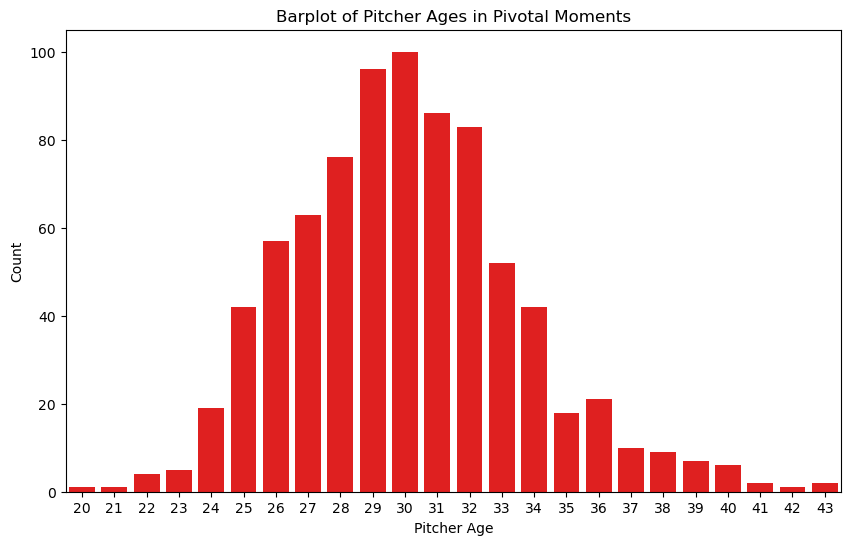

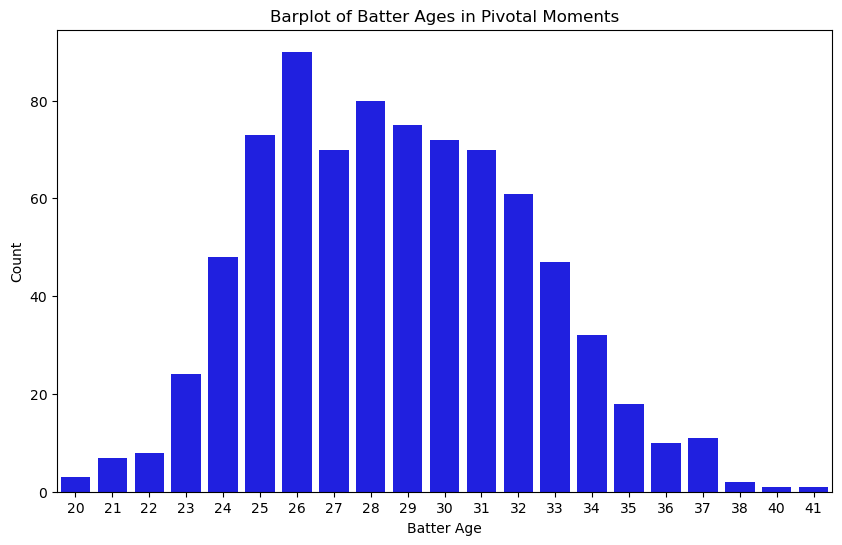

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(x='age_pit', data=pivotal_moment_data, color='red')
plt.xlabel('Pitcher Age')
plt.ylabel('Count')
plt.title('Barplot of Pitcher Ages in Pivotal Moments')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='age_bat', data=pivotal_moment_data, color='blue')
plt.xlabel('Batter Age')
plt.ylabel('Count')
plt.title('Barplot of Batter Ages in Pivotal Moments')
plt.show()


### Find median ages of batters and pitchers
Categorize each batter and hitter as young/old

In [10]:
pitcher_age_median = pivotal_moment_data['age_pit'].median()
batter_age_median = pivotal_moment_data['age_bat'].median()
print(f"Median Pitcher Age: {pitcher_age_median}")
print(f"Median Batter Age: {batter_age_median}")

pivotal_moment_data['pit_age_cat'] = np.where(pivotal_moment_data['age_pit'] > pitcher_age_median, 'old', 'young')
pivotal_moment_data['bat_age_cat'] = np.where(pivotal_moment_data['age_bat'] > batter_age_median, 'old', 'young')

# Move the new age category columns next to the corresponding age columns
cols = list(pivotal_moment_data.columns)
for age_col, cat_col in [('age_pit', 'pit_age_cat'), ('age_bat', 'bat_age_cat')]:
    cols.remove(cat_col)
    age_idx = cols.index(age_col)
    cols.insert(age_idx + 1, cat_col)
pivotal_moment_data = pivotal_moment_data[cols]

Median Pitcher Age: 30.0
Median Batter Age: 28.0
